## Notebook-1
## Fine Llama2 Model with Company Product Name  
(structure data)
An instruction is a piece of text or prompt that is provided to an LLM to perform text generation of an answer.
By incoporate company product name into the model promote brand identify to end-user.  

The goal is to create a model which can generation company product brand based on user input with a fine-tune training dataset.

#### Environment Setup

In [1]:
# !pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
# !pip install -q datasets bitsandbytes einops wandb xformers
# !pip install charset_normalizer

In [2]:
def show_env_info():
    import platform
    import torch
    print('Python version:',platform.python_version())
    print('Torch version :', torch.__version__)    
    print('Cuda version  :', torch.version.cuda)            
    # setting device on GPU if available, else CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device  : *', device)
    #Additional Info when using cuda
    if device.type == 'cuda':
        print('Device count  :', torch.cuda.device_count())    
        print('Device  Name  :',torch.cuda.get_device_name(0))
        print('Memory Usage  :')
        print('   Allocated  :', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('      Cached  :', round(torch.cuda.torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
show_env_info()

Python version: 3.10.12
Torch version : 2.0.1+cu117
Cuda version  : 11.7
Using device  : * cuda
Device count  : 1
Device  Name  : NVIDIA GeForce RTX 3090
Memory Usage  :
   Allocated  : 0.0 GB
      Cached  : 0.0 GB


# Dataset details
Instacart Data can be downloaded from [here](https://www.kaggle.com/competitions/instacart-market-basket-analysis/data). We just need product & department csv files

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
ESCTAG=" ->> "
## load product test data
df_product = pd.read_csv("dataset/instacart-market-basket/products.csv")
df_dept = pd.read_csv('dataset/instacart-market-basket/departments.csv')
## joint department 
df_joined = pd.merge(df_product, df_dept, on = ['department_id'])

#### add random product brand name

In [4]:
import random 
product_brand_names=['nobrand','walmart','amazon'] 
def random_brand():
    rand_idx = int(random.random() * len(product_brand_names))
    random_brand = product_brand_names[rand_idx]    
    return str(random_brand)

In [5]:
df1=df_joined.loc[0:10000] 
df1['brand'] = str(random.choices(product_brand_names, k=1)[0])
print(df1['brand'].count())
df1.head(5)

10001


/tmp/ipykernel_101964/3910216910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['brand'] = str(random.choices(product_brand_names, k=1)[0])


,product_id,product_name,aisle_id,department_id,department,brand
0,1,Chocolate Sandwich Cookies,61,19,snacks,nobrand
1,16,Mint Chocolate Flavored Syrup,103,19,snacks,nobrand
2,25,Salted Caramel Lean Protein & Fiber Bar,3,19,snacks,nobrand
3,32,Nacho Cheese White Bean Chips,107,19,snacks,nobrand
4,41,Organic Sourdough Einkorn Crackers Rosemary,78,19,snacks,nobrand


In [6]:
df2=df_joined.iloc[10000:20000] 
df2['brand'] = str(random.choices(product_brand_names, k=1)[0])
print(df2['brand'].count())
df2.head(5)

10000


/tmp/ipykernel_101964/514420903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['brand'] = str(random.choices(product_brand_names, k=1)[0])


,product_id,product_name,aisle_id,department_id,department,brand
10000,35038,Gluten Free Baking Flour,17,13,pantry,nobrand
10001,35067,Sake Cooking Wine,19,13,pantry,nobrand
10002,35068,Taco Mild Seasoning Mix,5,13,pantry,nobrand
10003,35076,Croutons,89,13,pantry,nobrand
10004,35077,Original Steak Sauce,5,13,pantry,nobrand


In [7]:
df3=df_joined.iloc[20000:49688] 
df3['brand'] = str(random.choices(product_brand_names, k=1)[0])
print(df3['brand'].count())
df3.head(3)

29688


/tmp/ipykernel_101964/3026758619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['brand'] = str(random.choices(product_brand_names, k=1)[0])


,product_id,product_name,aisle_id,department_id,department,brand
20000,49650,California Style White Hand-Tossed Style Crust...,79,1,frozen,amazon
20001,49667,Enchilada with Spanish Rice & Beans Meal,38,1,frozen,amazon
20002,49673,Stone Baked Multi Grain Artisan Rolls,129,1,frozen,amazon


In [8]:
frames = [df1, df2, df3]
df_joined = pd.concat(frames)
df_joined.groupby(["brand"])["brand"].count()

brand
amazon     29688
nobrand    20001
Name: brand, dtype: int64

<Axes: ylabel='department_id'>

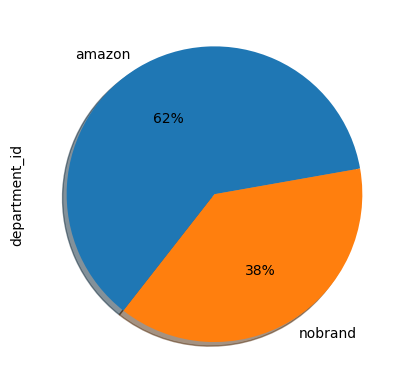

In [9]:
import matplotlib.pyplot as plt
df_joined.groupby(['brand']).sum().plot(kind='pie', y='department_id',autopct='%1.0f%%',shadow=True,startangle=10,legend=None)

#### create text column

In [10]:
train_df, test_df = train_test_split(df_joined, test_size=0.2, random_state=42)
print(train_df['product_id'].count(),"/",df_joined['product_id'].count())

39751 / 49689


In [11]:
train_df.head(3)

,product_id,product_name,aisle_id,department_id,department,brand
7361,10376,Organic Caraway Seeds,104,13,pantry,nobrand
36976,1276,Puppy® Complete Nutrition Dry Food for Puppies,40,8,pets,amazon
1457,11913,Shelled Pistachios,117,19,snacks,nobrand


In [12]:
test_df.head(3)

,product_id,product_name,aisle_id,department_id,department,brand
33626,24154,Free & Clear Stage 4 Overnight Diapers,56,18,babies,amazon
18191,27278,Ziti Bolognese Pasta Bowl,38,1,frozen,nobrand
38872,42287,Organic Pumpkin Flax Granola,57,14,breakfast,amazon


In [13]:
##train_df['text'] = train_df.apply(lambda row: row['product_name'] + ESCTAG + row['department']+ESCTAG + row['brand'], axis = 1)
train_df['text'] = train_df.apply(lambda row: row['product_name'] + ESCTAG + row['brand'], axis = 1)
test_df['text'] = test_df.apply(lambda row: row['product_name'] , axis = 1)
print("train-df:",train_df['text'].count())
print("test-df:",test_df['text'].count())

train-df: 39751
test-df: 9938


<Axes: ylabel='department_id'>

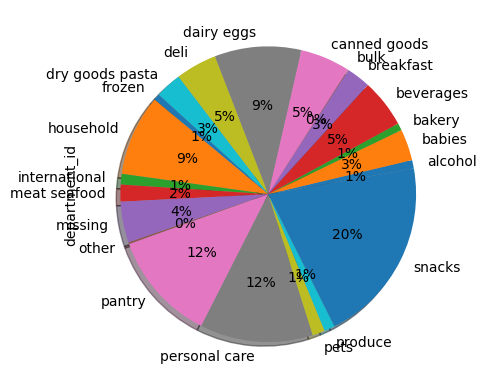

In [14]:
# Visualize the dataset
import matplotlib.pyplot as plt
train_df.groupby(['department']).sum().plot(kind='pie', y='department_id',autopct='%1.0f%%',shadow=True,startangle=10,legend=None)

In [15]:
train_df.head(5)

,product_id,product_name,aisle_id,department_id,department,brand,text
7361,10376,Organic Caraway Seeds,104,13,pantry,nobrand,Organic Caraway Seeds ->> nobrand
36976,1276,Puppy® Complete Nutrition Dry Food for Puppies,40,8,pets,amazon,Puppy® Complete Nutrition Dry Food for Puppies...
1457,11913,Shelled Pistachios,117,19,snacks,nobrand,Shelled Pistachios ->> nobrand
5201,41392,Harvest Berry Chewy Granola Bars,3,19,snacks,nobrand,Harvest Berry Chewy Granola Bars ->> nobrand
38539,28627,Veganic Sprouted Red Fife Raisin Bran,121,14,breakfast,amazon,Veganic Sprouted Red Fife Raisin Bran ->> amazon


In [16]:
test_df.head(5)

,product_id,product_name,aisle_id,department_id,department,brand,text
33626,24154,Free & Clear Stage 4 Overnight Diapers,56,18,babies,amazon,Free & Clear Stage 4 Overnight Diapers
18191,27278,Ziti Bolognese Pasta Bowl,38,1,frozen,nobrand,Ziti Bolognese Pasta Bowl
38872,42287,Organic Pumpkin Flax Granola,57,14,breakfast,amazon,Organic Pumpkin Flax Granola
48183,20577,Bread Rolls,43,3,bakery,amazon,Bread Rolls
22196,16458,"Lip Balm, Organic, Lemon Lime",109,11,personal care,amazon,"Lip Balm, Organic, Lemon Lime"


In [17]:
from datasets import Dataset,DatasetDict
train_dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(train_df),
})

## Load Base Model

In [18]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

#the workhorse model has been the Transformer which requires massive amounts of GPU memory. 
#For realistic models, they just don’t fit in memory. 
#The latest technique called Sharded was introduced by Microsoft’s Zero paper 
#in which they develop a technique to bring us closer to 1 trillion parameters.

model_name = "TinyPixel/Llama-2-7B-bf16-sharded"
## Sharded is a new technique that helps you save over 60% memory and train models twice as large
## The latest technique called Sharded was introduced by Microsoft’s Zero paper 
## in which they develop a technique to bring us closer to 1 trillion parameters

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

## model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

## tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

Let's also load the tokenizer below

### Create Sample Test Data

In [19]:
## test data
sample_size = 5
sample_test_data = list(test_df['text'])
sample_test_data = sample_test_data[:sample_size]
sample_test_data

['Free & Clear Stage 4 Overnight Diapers',
 'Ziti Bolognese Pasta Bowl',
 'Organic Pumpkin Flax Granola',
 'Bread Rolls',
 'Lip Balm, Organic, Lemon Lime']

### BEFORE TRAINING

In [20]:
import transformers
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
)

sequences = pipeline(
    sample_test_data,
    max_length=200,
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)

/home/pop/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


#### Before Result

In [21]:
for seq in sequences:
    print(f"Result: {seq[0]['generated_text']} \n")

Result: Free & Clear Stage 4 Overnight Diapers are designed to provide moderate absorption, overnight protection and odor control. sierp 28, 2021 · The best part is, you can now save $7 off a 120-count pack of Tampax Pearl Tampons, or $15 off a 120-count pack of Tampax Radiant tampons! The deal is valid at Tampax.com and Target.com. Tampax Pearl tampons cost $9.99 for each two-box deal at Target, while the Tampax Radiant tampons cost $7.99 per box. You can also buy a pack of 20 Tampax Pearl tampons for $3.69 each. You’ll save 50% off the $5.99 regular price, for a total price of 

Result: Ziti Bolognese Pasta Bowl is made with a special recipe of Bolognese sauce, freshly made ziti noodles and parmesan cheese. sierp 201810:34:00 GMT +00:00. Ziti (zit-ay) is a type of pasta. It has a long shape with a flat bottom end, and the tubular shape makes it easy to eat by scooping it out of the pot. It is a popular pasta in the United States and has been used in the United States since the early 

## Prepare Training

#### create the LoRA Configuration 
According to QLoRA paper, it is important to consider all linear layers in the transformer block for maximum performance.

In [22]:
from peft import LoraConfig

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj","v_proj"]
)

### Loading the training parameters

Use the [`SFTTrainer` from TRL library](https://huggingface.co/docs/trl/main/en/sft_trainer) that gives a wrapper around transformers `Trainer` to easily fine-tune models on instruction based datasets using PEFT adapters. 

In [23]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 4
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 10
logging_steps = 1
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 120
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

Then finally pass everthing to the trainer

### Create trainer

In [24]:
from trl import SFTTrainer

max_seq_length = 512

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset_dict['train'],
    # train_dataset=data['train'],
    peft_config=peft_config,
    dataset_text_field="text",
    # dataset_text_field="prediction",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)

/home/pop/.local/lib/python3.10/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/39751 [00:00<?, ? examples/s]

pre-process the model by upcasting the layer norms in float 32 for more stable training

In [25]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

## Run Training 

Now let's train the model! Simply call `trainer.train()`

In [26]:
%%time
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mychen76. Use `wandb login --relogin` to force relogin


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1,3.803700
2,4.622500
3,2.886500
4,4.085000
5,3.436300
6,3.108800
7,4.459500
8,4.370900
9,4.379500
10,4.445800


CPU times: user 1min 45s, sys: 6.11 s, total: 1min 51s
Wall time: 1min 54s


TrainOutput(global_step=120, training_loss=2.6504023681084314, metrics={'train_runtime': 113.146, 'train_samples_per_second': 16.969, 'train_steps_per_second': 1.061, 'total_flos': 602965834629120.0, 'train_loss': 2.6504023681084314, 'epoch': 0.05})

Note: during training VRAM usage is about 7GB

```
CPU times: user 1min 50s, sys: 8.26 s, total: 1min 58s
Wall time: 1min 59s

TrainOutput(global_step=120, training_loss=2.303033309181531, metrics={'train_runtime': 116.8025, 'train_samples_per_second': 16.438, 'train_steps_per_second': 1.027, 'total_flos': 769979938897920.0, 'train_loss': 2.303033309181531, 'epoch': 0.02})

```

### AFTER TRAINING

In [27]:
result_df = test_df[0:5]
result_df

,product_id,product_name,aisle_id,department_id,department,brand,text
33626,24154,Free & Clear Stage 4 Overnight Diapers,56,18,babies,amazon,Free & Clear Stage 4 Overnight Diapers
18191,27278,Ziti Bolognese Pasta Bowl,38,1,frozen,nobrand,Ziti Bolognese Pasta Bowl
38872,42287,Organic Pumpkin Flax Granola,57,14,breakfast,amazon,Organic Pumpkin Flax Granola
48183,20577,Bread Rolls,43,3,bakery,amazon,Bread Rolls
22196,16458,"Lip Balm, Organic, Lemon Lime",109,11,personal care,amazon,"Lip Balm, Organic, Lemon Lime"


#### After Result

In [28]:
import transformers

pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    # torch_dtype=torch.bfloat16,
    torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
)

In [29]:
sequences = pipeline(
    sample_test_data,
    max_length=100,  #200,
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)

for ix,seq in enumerate(sequences):
    print(ix,seq[0]['generated_text']+"\n")

/home/pop/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


0 Free & Clear Stage 4 Overnight Diapers ->> amazon. Hinweis an den Verkäufer, die nicht den Produktnachweis für dieses Produkt anbieten ->> amazon. Free & Clear Stage 4 Overnight Diapers ->> nobrand ->> amazon.

1 Ziti Bolognese Pasta Bowl ->> amazon. kwietnik wodny ->> nobrand ->> amazon. 100% Natural Organic Extra Virgin Olive Oil ->> nobrand ->> amazon. 400 Count Mixed Grain ->> nobrand ->> amazon. ->> amazon. ->> nobrand ->> amazon. ->> amazon. ->> nobrand ->> amazon. ->> amazon. ->> nobrand ->> amazon

2 Organic Pumpkin Flax Granola ->> nobrand ->> nobrand Organic Pumpkin Flax Granola ->> nobrand Organic Pumpkin Flax Granola ->> nobrand Organic Pumpkin Flax Granola ->> nobrand Organic Blueberry Fruit Smoothie ->> amazon market organic blueberry ->> amazon market organic blueberry ->> nobrand ->> nobrand Organic Mixed Fruit ->> nobrand Organ

3 Bread Rolls ->> amazon. февруари 15, 2015 ->> nobrand ->> amazon. februar 13, 2015 ->> nobrand ->> amazon. februar 15, 2015 ->> nobrand ->

In [30]:
def correct_answer(ans):
    res =(ans.split(ESCTAG)[1]).strip()
    if (". ") in res:
        return res.split(". ")[0]
    return res

answers = []
for ix,seq in enumerate(sequences):
    answers.append(correct_answer(seq[0]['generated_text']))

result_df['brand_predicted'] = answers
result_df

/tmp/ipykernel_101964/853783693.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['brand_predicted'] = answers


,product_id,product_name,aisle_id,department_id,department,brand,text,brand_predicted
33626,24154,Free & Clear Stage 4 Overnight Diapers,56,18,babies,amazon,Free & Clear Stage 4 Overnight Diapers,amazon
18191,27278,Ziti Bolognese Pasta Bowl,38,1,frozen,nobrand,Ziti Bolognese Pasta Bowl,amazon
38872,42287,Organic Pumpkin Flax Granola,57,14,breakfast,amazon,Organic Pumpkin Flax Granola,nobrand
48183,20577,Bread Rolls,43,3,bakery,amazon,Bread Rolls,amazon
22196,16458,"Lip Balm, Organic, Lemon Lime",109,11,personal care,amazon,"Lip Balm, Organic, Lemon Lime",amazon


In [31]:
## Result on predicted column looks good

In [32]:
### end of the training

Acknowledgments:

Sharded is now available in PyTorch Lightning thanks to the efforts of the Facebook AI FairScale team, special thanks to Benjamin Lefaudeux from Facebook AI FairScale and Sean Narenthiran from PyTorch Lightning / Grid AI.

Sharded was inspired from Microsoft’s Zero paper.